In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

In [3]:
import sys
sys.path.append("./../../")

from config_reader import ConfigReader
from modules.dvae.model import DVAE
from modules.transformer_gen.ar_cond_2stream.generator import LatentGenerator
from datasets.mnist_loader import MNISTData
from notebooks.utils import show
from modules.common_utils import latent_to_img
from utilities.md_mnist_utils import LabelsInfo

In [5]:
config_path = '/u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/trArC2s_mnistmd_v256_ds2_nb12_cnb6_remote.yaml'
CONFIG = ConfigReader(config_path=config_path)
CONFIG.print_config_info()

BATCH_SIZE                              12                                      
DEVICE                                  cuda                                    
LR                                      0.001                                   
LR_gamma                                0.1                                     
NUM_EPOCHS                              20                                      
cond_num_blocks                         6                                       
cond_seq_size                           12                                      
cond_vocab_size                         20                                      
config_path                             /u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/trArC2s_mnistmd_v256_ds2_nb12_cnb6_remote.yaml
dropout_prob                            0.1                                     
hidden_dim                              256                                     
hidden_height                           32                

In [6]:
data_source = MNISTData(
    img_type=CONFIG.type,
    root_path=CONFIG.root_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader()

In [22]:
from modules.common_blocks import TrEncoderBlock
from modules.common_utils import subsequent_mask

class LatentGenerator(nn.Module):
    def __init__(self,
                 hidden_width,
                 hidden_height,
                 embedding_dim,
                 num_blocks,
                 cond_seq_size,
                 cond_vocab_size,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob,
                 device=torch.device('cpu')):
        super(LatentGenerator, self).__init__()
        self.device = device

        self.hidden_width = hidden_width
        self.hidden_height = hidden_height
        self.embedding_dim = embedding_dim
        self.cond_seq_size = cond_seq_size

        self.proj_in = nn.Linear(embedding_dim, embedding_dim)
        self.proj_out = nn.Linear(embedding_dim, embedding_dim)

        self.pe_col = nn.Parameter(torch.randn(hidden_width, 1, embedding_dim))
        self.pe_row = nn.Parameter(torch.randn(hidden_height, 1, embedding_dim))
        self.pe_cond = nn.Parameter(torch.randn(cond_seq_size, 1, embedding_dim))

        self.tr_encoder_blocks = nn.ModuleList([
            TrEncoderBlock(n_features=embedding_dim,
                           n_attn_heads=n_attn_heads,
                           n_hidden=hidden_dim,
                           dropout_prob=dropout_prob)
            for _ in range(num_blocks)
        ])

        self.cond_encoder = nn.Sequential(
            nn.Embedding(num_embeddings=cond_vocab_size, embedding_dim=embedding_dim)
        )

        self.to(self.device)

    def forward(self, x, condition):
        seq_len, batch, emb = x.size()
        full_seq_len = self.cond_seq_size + seq_len

        mask = subsequent_mask(full_seq_len).to(x.device)

        x = self.proj_in(x)
        pe_column = self.pe_col.repeat(self.hidden_width, 1, 1)
        pe_row = self.pe_row.repeat_interleave(self.hidden_height, dim=0)
        x = x + pe_column + pe_row

        c = self.cond_encoder(condition)
        c = c + self.pe_cond.repeat(1, batch, 1)

        full_x = torch.cat([c, x], dim=0)

        for i, block in enumerate(self.tr_encoder_blocks):
            full_x = block(full_x, attn_mask=mask)

        x_out = self.proj_out(full_x[self.cond_seq_size:,:,:])
        return x_out

In [23]:
dvae = DVAE(
    in_channels=CONFIG.in_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.num_x2downsamples,
    num_resids_downsample=CONFIG.num_resids_downsample,
    num_resids_bottleneck=CONFIG.num_resids_bottleneck,
    hidden_dim=CONFIG.hidden_dim,
    device=CONFIG.DEVICE)

G = LatentGenerator(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    cond_seq_size=CONFIG.cond_seq_size,
    cond_vocab_size=CONFIG.cond_vocab_size,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob,
    device=CONFIG.DEVICE)

dvae.eval()
G.eval()

dvae.load_model(
    root_path=CONFIG.vae_model_path,
    model_name=CONFIG.vae_model_name)

# G.load_model(CONFIG.model_path, CONFIG.model_name)

pass

In [24]:
img, label = next(iter(train_loader))

img = img.to(CONFIG.DEVICE)
label = label.permute(1,0).to(CONFIG.DEVICE)

with torch.no_grad():
    latent = dvae.ng_q_encode(img)

b, emb, h, w = latent.size()
x = latent.view(b, emb, -1).permute(2, 0, 1)

In [25]:
r = G(x, label)

In [8]:
description = [
    ['8', '30', 'r', 'up', '3', '20', 'g', 'up', '2', '20', 'w', 'middle'],
    ['5', '30', 'g', 'middle', '2', '30', 'w', 'down', '4', '20', 'w', 'down'],
    ['5', '40', 'r', 'down', '3', '30', 'w', 'middle', '0', '40', 'b', 'down'],
    ['8', '20', 'g', 'down', '7', '40', 'w', 'middle', '2', '20', 'w', 'middle'],
    ['9', '30', 'r', 'middle', '2', '30', 'w', 'down', '2', '40', 'r', 'down'],
    ['5', '30', 'g', 'up', '2', '40', 'g', 'up', '6', '40', 'w', 'down'],
    ['8', '30', 'g', 'middle', '4', '30', 'b', 'middle', '0', '40', 'r', 'up'],
    ['6', '30', 'b', 'down', '4', '20', 'b', 'middle', '1', '20', 'g', 'down']
]

json_path = '/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/multi_descriptive_MNIST/description/labels_info.json'
li = LabelsInfo(json_path)

description_ids = li.encode_values(description)

description_tensor = torch.LongTensor(description_ids).T.to(CONFIG.DEVICE)

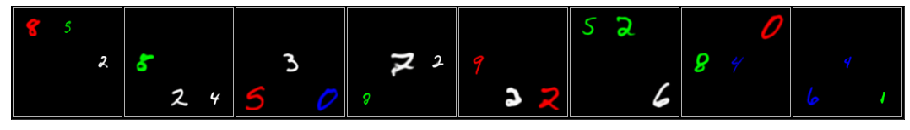

In [9]:
with torch.no_grad():
    gen_lat = G.sample(description_tensor)

gen_img = latent_to_img(gen_lat, dvae, CONFIG.hidden_height, CONFIG.hidden_width)

show(gen_img, figsize=(16,16), plot_grid=True)